# Notebook final

## Estructura de archivos y carpetas


* **Code** *Códigos + matlab*
    * **External** *Continene JIDT*
    * **MatlabIsing** *Contiene el código de Matlab para ajuste de modelo ising*
        * **Rasters** *Contiene los rasters para usar en matlab*
        * **Models** *Contiene los modelos generados por matlab*
    * *DataDetails.json - Archivo de conjuntos*
    * *JITDWrapper.py - Wrapper para usar JITD de external*
* **Data** *Carpeta de matrices previamente guardadas*
    * **PreComputed** *Archivos calculados*
        * **MI** *Matrices de información mutua*
        * **H** *Vectores de entropía*
        * *Archivo de distancias de campos receptivos*
        * *Archivo de spikes de 4 retinas bajo 5 estímulos*
* **Documents**
    * *Propuesta - Propuesta de la solución que se propone para lograr lo esperado*
    * *Plan de Implementación - Avances progresivos en el código y propuestas*
    * *Fundamentos - Algunas detalles matemáticos de lo que se hace en el código*
            
**Estructura de nombres de archivos**
    
Se definen los nombres tanto de rasters como de modelos en matlab de la siguiente manera:

`E_C_T_N_R_P_F_S_.mat`

Luego de cada letra sigue un número o numeros que representan lo siguiente

|Letra|Número|
|---|---|
|E|Número de Retina|
|C|Estímulo presentado|
|T|Tiempo de binning|
|N|Neurona a predecir|
|R|Tipo de ranking|
|P|Porcentaje de raster|
|F|Número de neuronas|
|S|Número de sample|

Para los casos de criterio de ranking y sección de raster, el detalle es el siguiente

|Nro|Ranking|Nro|Sección|
|---|---|---|---|
|0|Aleatorio|0|100%|
|1|Aleatorio Incremental|1|70%|
|2|Información Mutua| | 
|3|Distancia de campo receptivo| | 
|4|Correlación| | 

Para la estructura de las predicciones se utiliza el siguiente identificador dentro del archivo `N_.pkl`

`(R,P,F,S,PP)`

Donde las letras `R,P,F,S` corresponden a las definiciones anteriores, y el `PP` Corresponde a lo que fue predicho.

|Nro|Sección|
|---|---|
|0|100%|
|1|70%|
|2|30%| 



## Secciones del código

1. **Preliminares**
    1. Imports
    2. Definición de parametros fijos
    3. Carga/Cómputo de variables almacenadas de uso constante
2. **Selección de neuronas**
    1. Carga de archivo de conjunto de neuronas **(*)**
    2. Computa los conjuntos de neuronas
        1. Aleatorio (5 x 10/20/50/100/120/150)
        2. Aleatorio Incremental (5 x 10/20/50/100/120/150)
        3. En base a información Mutua (1 x 1:10/20/50/100/120/150)
        4. En base a Correlación (1 x 1:10/20/50/100/120/150)
        5. En base a Distancia de Campos receptivos (1 x 1:10/20/50/100/120/150)
3. **Creación de Modelos (\*\*)**
    1. Exportar rasters a formato MATLAB
        1. En formato Completo/Train 70%
    2. Exportar las lineas de código para ejecutar sobre MATLAB
    3. Ejecutar MATLAB **(Externo)**
4. **Cálculo de predicciónes**
    1. Función de predicción de raster en base a modelo
    2. Llamadas a la función de preducción y guardado de resultados
5. **Cálculo de métricas**
    1. Función de cálculo de métricas en base a resultados
    2. Llamadas a función de cálculo de métricas y guardado de resultados
6. **Gráficos**
    1. Visualizar predicciones v/s datos originales
    2. Obtener graficos de las métricas según distintos parámetros
    3. Obtener los espacios de las métricas
7. **Adicionales**
    1. Eliminación de rasters **(\*\*\*)**
    
**(*)** = Sólo si el archivo existe, o de lo contrario se generará uno en el punto 2.

**(\*\*)** = Es necesario hacer esto sólo una vez.

**(\*\*\*)** = Los rasters de matlab sólo se utilizan en el punto 3 y luego se trabaja con los modelos, su generación puede ser muy pesada. En caso de necesitarse nuevamente su generación es rápida y se basa en el archivo de conjuntos del punto 2.

In [24]:
### 1 - Preliminares

#### Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import os
import pickle
from matplotlib.ticker import ScalarFormatter
from ipywidgets import interact,interact_manual,IntSlider
from scipy.io import loadmat,savemat
from scipy.ndimage.filters import gaussian_filter1d
from scipy import sparse
from json import loads,dumps
from jpype import *
from JITDWrapper import *
from sklearn.manifold import MDS
from scipy.spatial import ConvexHull

%matplotlib inline

#### Parámetros Fijos
EXP = 0 # 0 1 2 3
COND = 3 # 0.issa 1.ifsa 2.wn 3.nm 4.ffsa 5. fssa
TBASE = 0.02 #0.001 = 1ms
RASTER = dataLoader(EXP,COND,TBASE)[0]
INTERVAL = 50 # para SpRate
N,T = RASTER.shape
J = 5
NsR = [10,20,50,100,120,N-1]
Ns = [4,5,6,7,8,9,10,20,50,100,120,N-1]
TP = 31 #Neurona a predecir
#### Cargas iniciales

D = loadmat("../Data/rfOverlap.mat")["rfDist"][0]
MI = MutualInformation(EXP,COND,TBASE)
MI = MI+MI.T
CC = np.corrcoef(RASTER[:50],RASTER[50:])**2-np.diag(np.ones(N))



Returning saved sparse matrix E0_C3_T0.02
Returning PreComputed MIMatrix E0_C3_T0.02


In [4]:
### 2 - Selección de neuronas
#### Carga de archivo
def cargarDataset(TP):
    if "N{0}.json".format(TP) in os.listdir("Datasets"):
        with open("Datasets/N{0}.json".format(TP)) as DD:
            dataset = loads(DD.readline())
        print("Carga de archivo existente para neurona {0}".format(TP))

    #### Creación de Archivo
    else:
        #fixed = int(np.random.choice(range(N)))
        fixed = TP
        free = np.array(list(set(range(N))-{fixed}))
        mienum = sorted([(x[1],x[0]) for x in enumerate(MI[fixed])],reverse=1) #mayor a menor
        miids = list([x[1] for x in mienum])
        miids.remove(fixed)
        cenum = sorted([(x[1],x[0]) for x in enumerate(CC[fixed])],reverse=1)
        cids = list([x[1] for x in cenum])[:-1]
        denum = sorted([(x[1],x[0]) for x in enumerate(D[fixed])])
        dids = list([x[1] for x in denum])[1:]
        dataset = {"fixed":fixed,
                   0:dict([(n,[sorted(np.random.choice(free,n,False).tolist()) for j in range(J)]) for n in NsR]),
                   1:{},
                   2:dict([(n,[miids[:n]]) for n in Ns]),
                   3:dict([(n,[dids[:n]]) for n in Ns]),
                   4:dict([(n,[cids[:n]]) for n in Ns])} 
        newsets=[np.random.choice(list(set(range(N))-{fixed}),N-1,False).tolist() for j in range(J)]
        for n in NsR:
            dataset[1][n]=[]
            for j in range(J):
                dataset[1][n].append(newsets[j][:n])
        with open("Datasets/N{0}.json".format(TP),"w") as DD:
            DD.write(dumps(dataset))
    return dataset
    
#dataset = {#tipo_selección:{#neuronas:[sample0,sample1,...]}} sampleN = [id0,id1,id2,...]


In [3]:
### 3 - Creación de modelos
#### Código para exportar a archivos MATLAB
def saveRasters(neuron):
    dataset=cargarDataset(neuron)
    for rank in [0,1,2,3,4]: #tipo de ranking
        if rank in [0,1]:
            flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
        else:
            flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            #flist,slist = [1,2,3],[0]#,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                savemat("MatlabIsing/Rasters/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,0,f,s),
                        {"binnedSpikes":RASTER[[neuron]+dataset[str(rank)][str(f)][s],:]})
                #savemat("MatlabIsing/Rasters/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,1,f,s),
                #        {"binnedSpikes":RASTER[[neuron]+dataset[str(rank)][str(f)][s],:int(T*0.7)]})
                #print ("Guardado MatlabIsing/Rasters/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,0,f,s))

#for localTP in range(85,115): #pend
#    saveRasters(localTP)
#    print(localTP,"OK")

In [4]:
#### Código para generar las lineas ejecutables en MATLAB
def modelsMatlabLines(neuron):
    filelist = []
    for rank in [0,1,2,3,4]: #tipo de ranking
        if rank in [0,1]:
            flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
        else:
            flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            #flist,slist = [1,2,3],[0]#,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                filelist.append("E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}".format(EXP,COND,TBASE,neuron,rank,0,f,s))
                #filelist.append("E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}".format(EXP,COND,TBASE,neuron,rank,1,f,s))
                #print ("Ajustar('{0}','{1}','{2}');".format('Rasters','Models',
                #                                            "E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,0,f,s)))
                #print ("Ajustar('{0}','{1}','{2}');".format('Rasters','Models',
                #                                            "E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,1,f,s)))
    return filelist

#matlines =  []
#for nn in range(85,115):
#    matlines = matlines+modelsMatlabLines(nn)
#matliness  = modelsMatlabLines(15)

In [6]:
# Del total de nuevos modelos cuantos faltan
foldercont = os.listdir("MatlabIsing/Models/")
rematlines=[f for f in matlines if f+".mat" not in foldercont]
print(len(matlines),len(rematlines))
#print(rematlines)

2880 0


In [148]:
# Evaluar cuantos rasters tienen sus modelos listos
rastercont = os.listdir("MatlabIsing/Rasters/")
modelcont = os.listdir("MatlabIsing/Models/")
print (len(set(rastercont)-set(modelcont)),len(modelcont),len(rastercont))


633 12219 3131


In [ ]:
### Correr los modelos en matlab
def run_matlab(filename,back=0):
    print("""matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('Rasters','Models','{}.mat');exit()" """.format(filename)+["","&"][back])
    return
    os.system("""matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('Rasters','Models','{}.mat');exit()" """.format(filename)+["","&"][back])

    
sortedlines = sorted(rematlines,key=lambda s: int(s[s.index("F")+1:s.index("S")]))
for sub in range(len(sortedlines))[::5]:
    sl =  sortedlines[sub:sub+5]
    print(sl)
    run_matlab(sl[0],1)
    run_matlab(sl[1],1)
    run_matlab(sl[2],1)
    run_matlab(sl[3],1)
    run_matlab(sl[4],0)


In [8]:
# Evaluar para cada neurona qué tipos de modelos tiene listos
# Recordar el xxxxxN__RxxP_S_ -> #Deben tener todos los ranks y samples para tener la base con P0
# Deben tener el P1 si es que son usados para ciclo completo
# Indicar que modelos faltan para cada caso (por ejemplo caso P0 o P1) si es que faltan solo algunos
# pares r,s = [2,3,4][4-10,20,50,100,120,150][0] y [0,1][10,20,50,100,120,150][0-4]
allmodels = os.listdir("MatlabIsing/Models/")
for neuron in range(151):
    count = 0
    search = "N{0}R".format(neuron)
    for file in allmodels:
        if search in file:
            count+=1
    if count==210:
        print("%3s" % neuron, "%4s" % count)

  2  210
 10  210
 20  210
 31  210
 49  210
 72  210
119  210
120  210
127  210
147  210


In [59]:
for sub in range(len(sortedlines))[::5][:-1]:
    sl =  sortedlines[sub:sub+5]
    print(sl)

['E0C3T0.02N23R3P0F4S0', 'E0C3T0.02N27R3P0F7S0', 'E0C3T0.02N29R4P0F10S0', 'E0C3T0.02N27R2P0F20S0', 'E0C3T0.02N27R1P0F50S3']


In [ ]:
#USED RASTER CLEANER
rastercont = os.listdir("MatlabIsing/Rasters/")
modelcont = os.listdir("MatlabIsing/Models/")
print (len(set(rastercont)-set(modelcont)),len(modelcont),len(rastercont))
for elem in modelcont:
    os.system("rm MatlabIsing/Rasters/"+elem) #deleting raster with model ready
    print("|",end="")

In [5]:
### 4 - Cómputo de predicciones
#### Función de predicción de raster o spikerate en base al modelo

def PredecirSpRate(TP,r,p,f,s,pp): #neurona,ranking,particion_entreno,fijas,set,particion_eval
    #Carga indices de neuronas y ajusta datos
    dataset=cargarDataset(TP)
    N = f+1
    neuronas = [dataset["fixed"]]+dataset[str(r)][str(f)][s] #Definicion de neuronas a usar desde dataset
    if pp == 0: #full
        data = RASTER[neuronas,:]
    elif pp == 1: #Partial Training
        data = RASTER[neuronas,:int(T*0.7)]
    else: #Partial Testing
        data = RASTER[neuronas,int(T*0.7):]
    print("R{0}P{1}F{2}S{3}PP{4}".format(r,p,f,s,pp),data.T.shape[0]) #DEBUG PRINT
    
    #Carga el modelo usando los params r/p/f/s 
    ising = loadmat("MatlabIsing/Models/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,dataset["fixed"],r,p,f,s))
    params = ising["params"] # N , N*(N-1)/2
    #print(params[:,0],len(params[:,0]),N)
    P = np.zeros((N,N)) #FullMatrix for indexing
    P[np.triu_indices(N, 1)] = params[:,0][N:] #UpperTri Matrix
    P = P+np.diag(params[:,0][:N]) #<h,sigma>
    
    #Calcula la probabilidad
    obtRate = []
    for t in range(data.T.shape[0]):
        selected = np.array([[1.0]+data.T[t][1:N].tolist(), [0.0]+data.T[t][1:N].tolist()]) # 1/0 + data 1:N
        prob_denom = np.sum(np.exp(np.sum(np.matmul(selected,P)*selected,1))) #Prob P(given)
        selected = np.array([[1.0]+data.T[t][1:N].tolist()]) #1 + data 1:N
        prob_num = np.sum(np.exp(np.sum(np.matmul(selected,P)*selected,1))) #Prob P(target,given)
        obtRate.append(prob_num/prob_denom)
    
    #SpikeRate Forward Moving Window
    spRate = np.array([np.sum(data[0][i:i+50]) for i in range(0,data.T.shape[0]-50)])/(1/TBASE)
    spRatePred = np.array([np.sum(obtRate[i:i+50]) for i in range(0,data.T.shape[0]-50)])/(1/TBASE)
    
    return obtRate,spRatePred

#### Llamado a la función y almacenamiento de predicción

def cargarPredicciones(TP):
    #Archivo exixstente
    dataset=cargarDataset(TP)
    if "N{0}.pkl".format(dataset["fixed"]) in os.listdir("Predictions/"):
        print("Cargando archivo existente Predictions/N{0}.pkl".format(dataset["fixed"]))
        f = open('Predictions/N{0}.pkl'.format(dataset["fixed"]), 'rb')   # 'rb' for reading binary file
        predicciones = pickle.load(f)     
        f.close()
        print("Ok")
    else: #Crea el archivo
        predicciones = {}
        for r in [0,1,2,3,4]: #tipo de ranking
            if r in [0,1]: #random
                flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
            else: #criterio
                flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            for f in flist: #neuronas fijadas
                for s in slist: #samples
                    for p in [0]: #Ratio de entrenamiento SOLAMENTE Full->Full
                        if p==0:
                            predicciones[(r,p,f,s,0)] = PredecirSpRate(TP,r,p,f,s,0) #Full a Full
                        else:
                            predicciones[(r,p,f,s,1)] = PredecirSpRate(TP,r,p,f,s,1) #Partial a Partial
                            predicciones[(r,p,f,s,2)] = PredecirSpRate(TP,r,p,f,s,2) #Partial a Testing
        f = open('Predictions/N{0}.pkl'.format(dataset["fixed"]), 'wb')
        pickle.dump(predicciones, f)          # dump data to f
        f.close()
    return predicciones
#predicciones[(r,p,f,s,0)] 0=full->full

#for p in range(85,115):
#    OUT = cargarPredicciones(p)

In [61]:
def reducPredicciones(TP):
    f = open('Predictions/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
    predicciones = pickle.load(f)     
    f.close()
    minipredicciones={}
    for r in [0,1,2,3,4]: #tipo de ranking
        if r in [0,1]: #random
            flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
        else: #criterio
            flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                minipredicciones[(r,0,f,s,0)] = predicciones[(r,0,f,s,0)][1][:3000]
    f = open('mPredictions/N{0}.pkl'.format(TP), 'wb')
    pickle.dump(minipredicciones, f)          # dump data to f
    f.close()
for p in range(115,151):
    reducPredicciones(p)


In [ ]:
#FIX PREDICCIONES
#correccion de r=2, f=completo s=0 p,pp = 1,1 y 1,2
def FixPredicc(TP):
    dataset=cargarDataset(TP)
    f = open('Predictions/N{0}.pkl'.format(dataset["fixed"]), 'rb')   # 'rb' for reading binary file
    predicciones = pickle.load(f)     
    f.close()
    for r in [2]: #tipo de ranking
        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                for p in [0,1]: #Ratio de entrenamiento
                    if p==0:
                        predicciones[(r,p,f,s,0)] = PredecirSpRate(TP,r,p,f,s,0) #Full a Full
                    else:
                        predicciones[(r,p,f,s,1)] = PredecirSpRate(TP,r,p,f,s,1) #Partial a Partial
                        predicciones[(r,p,f,s,2)] = PredecirSpRate(TP,r,p,f,s,2) #Partial a Testing
    f = open('Predictions/N{0}.pkl'.format(dataset["fixed"]), 'wb')
    pickle.dump(predicciones, f)          # dump data to f
    f.close()


In [6]:
### 5 - Cálculo de métricas
#### Función para calcular las métricas en base a una predicción
def ObtenerMetricas(TP,r,p,f,s,pp):
    #Original Data
    if pp == 0: #full
        data = RASTER[dataset["fixed"],:]
        spRate = np.array([np.sum(data[i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    elif pp == 1: #Partial Training
        data = RASTER[dataset["fixed"],:int(T*0.7)]
        spRate = np.array([np.sum(data[i:i+50]) for i in range(0,int(T*0.7)-50)])/(1/TBASE)
    else: #Partial Testing
        data = RASTER[dataset["fixed"],int(T*0.7):]
        spRate = np.array([np.sum(data[i:i+50]) for i in range(0,int(T*0.3)-50+1)])/(1/TBASE)
        
    # Predicted Data
    preData,preSp = predicciones[(r,p,f,s,pp)]
    print (p,pp,len(data),len(spRate),len(preData),len(preSp))
    #Raw Distance|R and SpRate Distance|R
    dataDist = np.round(np.linalg.norm(data-preData),3)
    dataR = np.round(np.corrcoef(data,preData)[0,1],3)
    spDist = np.round(np.linalg.norm(spRate-preSp),3)
    spR = np.round(np.corrcoef(spRate,preSp)[0,1],3)
    return [(dataDist,dataR),(spDist,spR)]
    
#### Llamados a función de cálculo de metricas y almacenamiento de los resultados
def cargarMedidas(TP):
    if "N{0}.pkl".format(TP) in os.listdir("Measures/"):
        #print("Cargando archivo existente Measures/N{0}.pkl".format(TP))
        f = open('Measures/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
        medidas = pickle.load(f)     
        f.close()
        #print("Ok")
    else:
        medidas = {}
        for r in [0,1,2,3,4]: #tipo de ranking
            if r in [0,1]:
                flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
            else:
                flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            for f in flist: #neuronas fijadas
                for s in slist: #samples
                    for p in [0,1]: #particiones
                        if p==0:
                            medidas[(r,p,f,s,0)] = ObtenerMetricas(TP,r,p,f,s,0) #de full a full
                        else:
                            medidas[(r,p,f,s,1)] = ObtenerMetricas(TP,r,p,f,s,1) #de parcial a training
                            medidas[(r,p,f,s,2)] = ObtenerMetricas(TP,r,p,f,s,2) #de parcial a testing
        f = open('Measures/N{0}.pkl'.format(TP), 'wb')
        pickle.dump(medidas, f)          # dump data to f
        f.close()
        print("OK")
    return medidas
#medidas = {(r,0,f,s,pp):[(dataDist,dataR),(spDist,spR)]}
#for M in [20]:
#    dataset=cargarDataset(M)
#    predicciones=cargarPredicciones(M)
#    m = cargarMedidas(M)

In [ ]:
def FixMedidas(TP):
    f = open('Measures/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
    medidas = pickle.load(f)     
    f.close()
    for r in [2]: #tipo de ranking
        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                for p in [0,1]: #particiones
                    if p==0:
                        medidas[(r,p,f,s,0)] = ObtenerMetricas(TP,r,p,f,s,0) #de full a full
                    else:
                        medidas[(r,p,f,s,1)] = ObtenerMetricas(TP,r,p,f,s,1) #de parcial a training
                        medidas[(r,p,f,s,2)] = ObtenerMetricas(TP,r,p,f,s,2) #de parcial a testing
    f = open('Measures/N{0}.pkl'.format(TP), 'wb')
    pickle.dump(medidas, f)          # dump data to f
    f.close()
    print("OK")
for fix in [147,127,120,119,49,31,20,2]:
    predicciones=cargarPredicciones(fix)
    FixMedidas(fix)

# WorkFlow

In [ ]:
# TP = 147
#medidas = {(r,0,f,s,pp)
# (p,pp) -> (0,0), (1,1), (1,2)
def measurePlotter(TP,pconv,plotfile):
    #predicciones = cargarPredicciones(TP)
    #print(TP)
    medidas = cargarMedidas(TP)
    plt.figure(figsize=(15,5))
    p,pp = [(0,0),(1,1),(1,2)][pconv]
    med = ["Distance","$R^2$"]
    tip = ["Spikes","Spike Rates"]
    A = 6
    B = 15
    for t in [1]:
        for m in [0,1]:
            #plt.figure(figsize=(16,15))
            #plt.subplot(4,1,m*2+t+1)
            plt.subplot(1,2,m+1)
            plt.xlabel("N");plt.ylabel(med[m])
            rand = [np.array([medidas[(0,p,f,s,pp)][t][m] for f in NsR[:A]]) for s in range(5)]
            irand = [np.array([medidas[(1,p,f,s,pp)][t][m] for f in NsR[:A]]) for s in range(5)]
            stdrand = np.std(rand,axis=0)
            stdirand = np.std(irand,axis=0)
            plt.plot(NsR[:A],sum(rand)/5,"k-",alpha=0.3,label="AvgRandom")
            plt.fill_between(NsR[:A], sum(rand)/5 - stdrand, sum(rand)/5 + stdrand, alpha=0.05,color="k")
            plt.plot(NsR[:A],sum(irand)/5,"b-",alpha=0.3,label="AvgRandom I")
            plt.fill_between(NsR[:A], sum(irand)/5 - stdirand, sum(irand)/5 + stdirand, alpha=0.05,color="b")
            #for s in range(4):
            #    plt.plot(NsR[:A],[medidas[(0,p,f,s,pp)][t][m] for f in NsR[:A]],"k.")
            #    plt.plot(NsR[:A],[medidas[(1,p,f,s,pp)][t][m] for f in NsR[:A]],"b-",alpha=0.3)
            plt.plot(Ns[:B],[medidas[(2,p,f,0,pp)][t][m] for f in Ns[:B]],"r-",alpha=0.3,label="MI")
            plt.plot(Ns[:B],[medidas[(3,p,f,0,pp)][t][m] for f in Ns[:B]],"g-",alpha=0.3,label="RF")
            plt.plot(Ns[:B],[medidas[(4,p,f,0,pp)][t][m] for f in Ns[:B]],"k-",alpha=0.3,label="Correl")
            plt.legend()
            plt.title("Neuron {0} - {2} {1}".format(TP,med[m],tip[t]))
    plt.savefig("plot{0}".format(dataset["fixed"])+plotfile+".svg")

for tp in [2,10,20,30]:
    dataset = cargarDataset(tp)    
    #measurePlotter(tp,2,"PT")
    measurePlotter(tp,0,"FF")

Carga de archivo existente para neurona 2
Carga de archivo existente para neurona 10
Carga de archivo existente para neurona 20
Carga de archivo existente para neurona 31
Carga de archivo existente para neurona 49
Carga de archivo existente para neurona 72
Carga de archivo existente para neurona 119
Carga de archivo existente para neurona 120
Carga de archivo existente para neurona 127
Carga de archivo existente para neurona 147


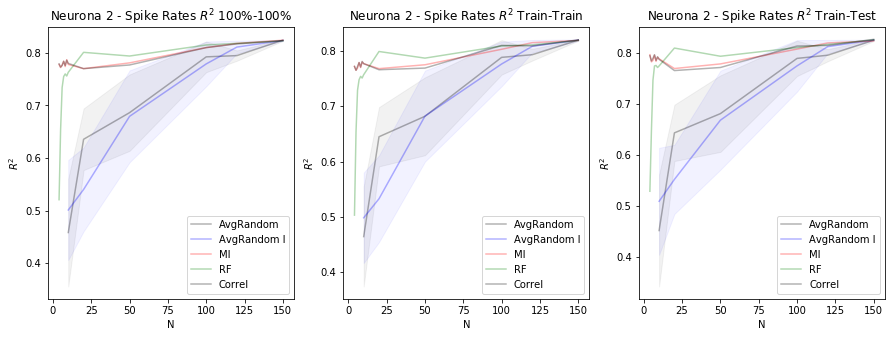

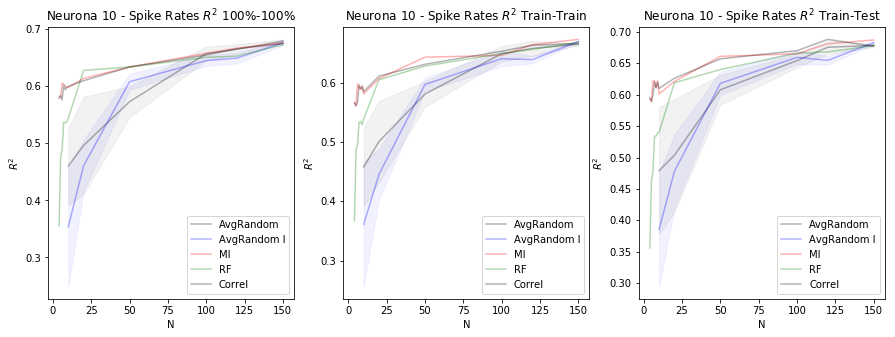

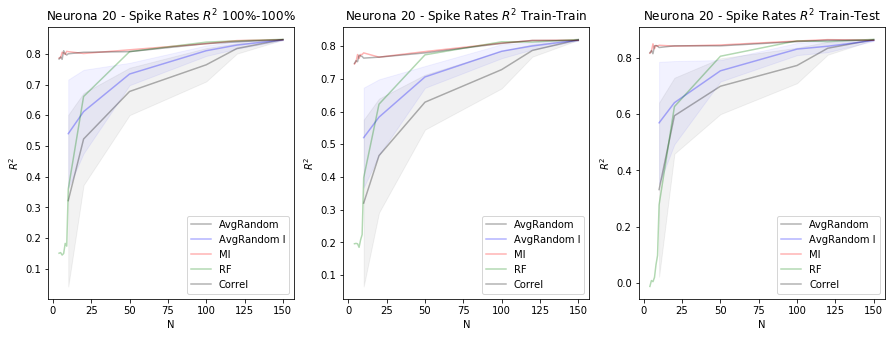

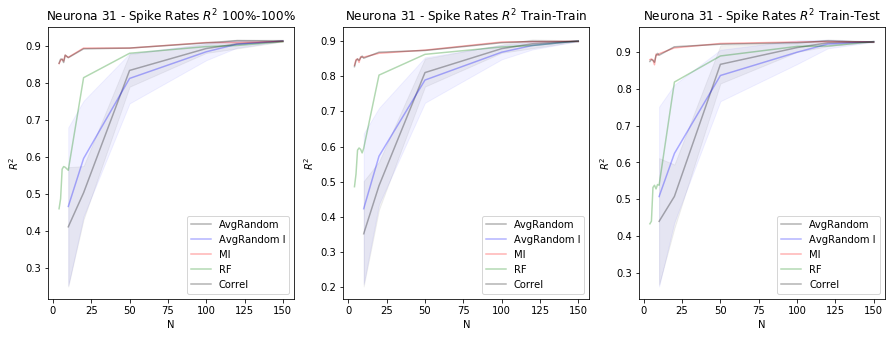

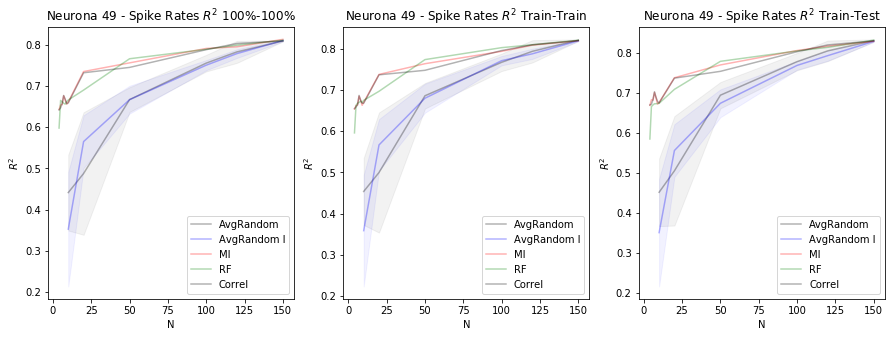

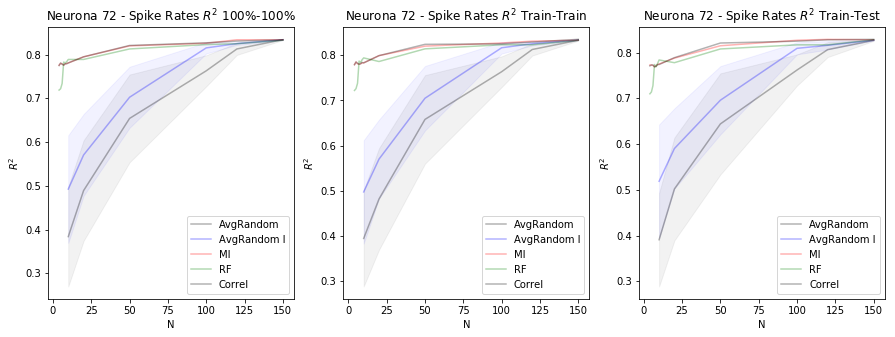

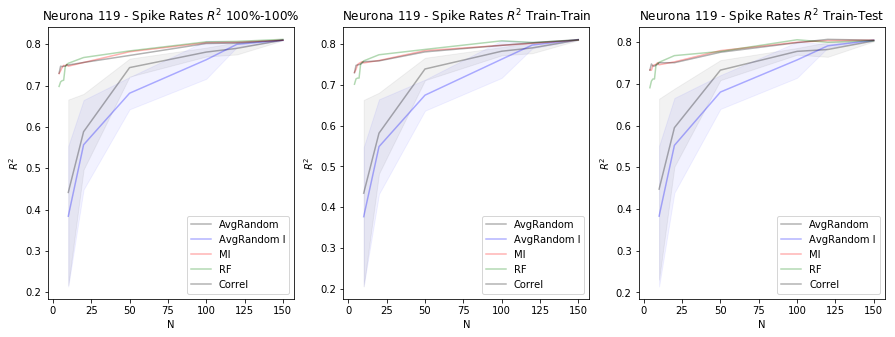

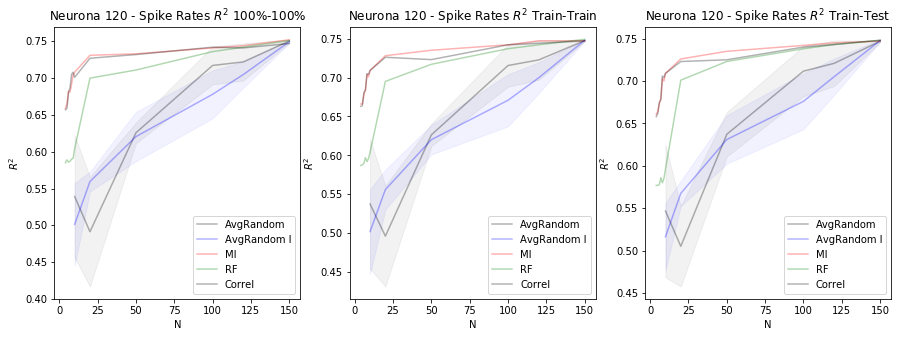

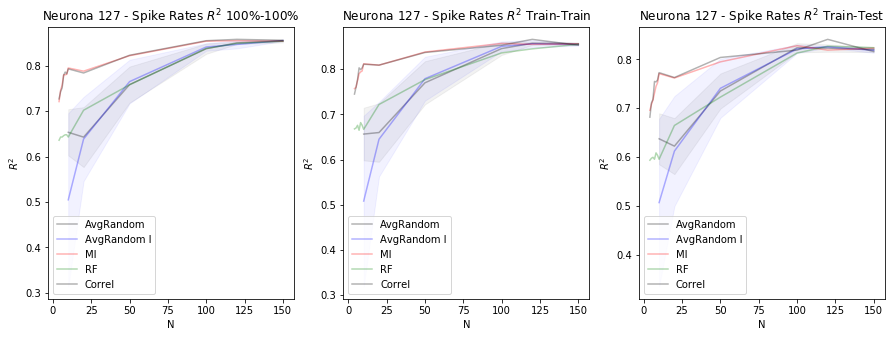

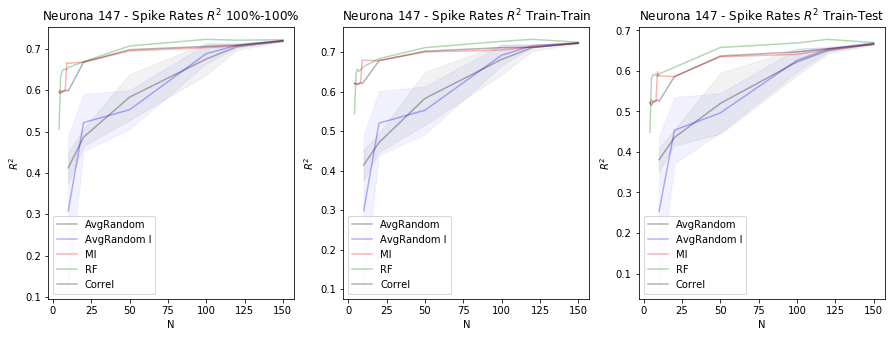

In [7]:
# TP = 147
#medidas = {(r,0,f,s,pp)
# (p,pp) -> (0,0), (1,1), (1,2)
def memoriaPlotter(TP,pconv,plotfile):
    #predicciones = cargarPredicciones(TP)
    #print(TP)
    medidas = cargarMedidas(TP)
    plt.figure(figsize=(15,5))
    #p,pp = [(0,0),(1,1),(1,2)][pconv]
    pselect = [(0,0),(1,1),(1,2)]
    med = ["Distance","$R^2$"]
    tip = ["Spikes","Spike Rates"]
    nom = ["100%-100%","Train-Train","Train-Test"]
    t,m= 1,1
    for pconv in [0,1,2]:
        p,pp = pselect[pconv]
        plt.subplot(1,3,pconv+1)
        plt.xlabel("N");plt.ylabel(med[m])
        rand = [np.array([medidas[(0,p,f,s,pp)][t][m] for f in NsR]) for s in range(5)]
        irand = [np.array([medidas[(1,p,f,s,pp)][t][m] for f in NsR]) for s in range(5)]
        stdrand = np.std(rand,axis=0)
        stdirand = np.std(irand,axis=0)
        plt.plot(NsR,sum(rand)/5,"k-",alpha=0.3,label="AvgRandom")
        plt.fill_between(NsR, sum(rand)/5 - stdrand, sum(rand)/5 + stdrand, alpha=0.05,color="k")
        plt.plot(NsR,sum(irand)/5,"b-",alpha=0.3,label="AvgRandom I")
        plt.fill_between(NsR, sum(irand)/5 - stdirand, sum(irand)/5 + stdirand, alpha=0.05,color="b")
        plt.plot(Ns,[medidas[(2,p,f,0,pp)][t][m] for f in Ns],"r-",alpha=0.3,label="MI")
        plt.plot(Ns,[medidas[(3,p,f,0,pp)][t][m] for f in Ns],"g-",alpha=0.3,label="RF")
        plt.plot(Ns,[medidas[(4,p,f,0,pp)][t][m] for f in Ns],"k-",alpha=0.3,label="Correl")
        plt.legend()
        plt.title("Neurona {0} - {2} {1} {3}".format(TP,med[m],tip[t],nom[pconv]))
        plt.savefig("plot{0}".format(dataset["fixed"])+plotfile+".svg")
#plt.plot(range(T-50)[:1000],np.array([np.sum(RASTER[dataset["fixed"]][i:i+50]) for i in range(0,T-50)])[:1000]/(1/TBASE))
#plt.plot(range(T-50)[:1000],predicciones[(0,0,50,4,0)][1][:1000])
#measurePlotter(0,"FullFull")
#measurePlotter(1,"PartialTrain")
#measurePlotter(2,"PartialTest")
#[2,31,49,72,119,120,127,147]
for tp in [2,10,20,31,49,72,119,120,127,147]:
    dataset = cargarDataset(tp)
    memoriaPlotter(tp,0,"FF")
    

In [ ]:
# PARAMS - PLOT
modname=matlines[80]
N=51
print(modname)
ising = loadmat("MatlabIsing/Models/{}.mat".format(modname))
params = ising["params"] # N , N*(N-1)/2
#print(params[:,0],len(params[:,0]),N)
P = np.zeros((N,N)) #FullMatrix for indexing
P[np.triu_indices(N, 1)] = params[:,0][N:] #UpperTri Matrix
H = np.diag(params[:,0][:N]) #<h,sigma>
sns.distplot(params[N:])

In [ ]:
# Measure Ranking per neuron -> Avg(Random), Avg(RandomInc), MI, C, RF 
# SpRate - R2 is absolute -> more is better
# default p,pp = 0,0
# default t,m = 1,1
def rankingMedidas(TP):
    p,pp =0,0
    medidas = cargarMedidas(TP)
    ranks = ["AvgRand","AvgIncRand","MI","RF","Corr"]
    norms = [np.linalg.norm(sum([np.array([medidas[(r,p,f,s,pp)][1][1] for f in NsR]) for s in range(ss)])/ss) for r,ss in [(0,5),(1,5),(2,1),(3,1),(4,1)]]
    norms = list(zip(ranks,norms))
    return list(zip(*sorted(norms,key=lambda x:x[1],reverse=True)))[0]

stats([10,2,20,31,49,72,119,120,127,147])
for n in [10,2,20,31,49,72,119,120,127,147]:
    print(n,rankingMedidas(n))

In [ ]:
def plotpredictedsprate(TP,r,f,s,window,steps,name="SpFigure"):
    data,SP = predicciones[(r,0,f,s,0)]
    #rank = {0:"Aleatorio",1:"Aleatorio Incremental",2:"por Información Mutua",4:"por Correlación",3:"por Campo Receptivo"}
    rank = {0:"Random",1:"Incremental Random",2:"Mutual Information Ranked",4:"Correlation Ranked",3:"Receptive Field Ranked"}
    sp = np.array([np.sum(RASTER[TP][i:i+window]) for i in range(0,T-window)])/(1/TBASE)
    #psp = np.array([np.sum(data[i:i+window]) for i in range(0,T-window)])/(1/TBASE)
    #totalact = np.sum(RASTER,axis=0)/RASTER.shape[0]
    #tsp = np.array([np.sum(totalact[i:i+window]) for i in range(0,T-window)])/(1/TBASE)
    ccoef = round(np.corrcoef(sp[:steps],SP[:steps])[0,1],2)
    ccoeft = round(np.corrcoef(sp[:],SP[:])[0,1],2)
    plt.figure(figsize=(25,5))
    #plt.title("Neurona {0} predicha en base a {1} neuronas del sample {2} {3} w_size={4} R2={5} // {6}".format(TP,f,s,rank[r],window,ccoef,ccoeft))
    plt.title("Neuron {0} predicted by {1} neurons from {3} sample {2} [w_size={4} R2={5} // tR2={6}]".format(TP,f,s,rank[r],window,ccoef,ccoeft))
    plt.plot(range(steps),gaussian_filter1d(sp[:steps],sigma=3),label="Original")
    #plt.plot(range(steps),gaussian_filter1d(psp[:steps],sigma=3),label="Predicted")
    plt.plot(range(steps),gaussian_filter1d(SP[:steps],sigma=3),label="Predicted")
    #plt.plot(range(steps),gaussian_filter1d(tsp[:steps],sigma=3),"--",label="RasterAverage",alpha=0.3)
    plt.ylabel("Spike Rate")
    plt.xlabel("Time Bin")
    plt.legend()
    plt.show()
    #m = max(max(sp[:steps]),max(psp[:steps]))
    #dists = np.array([np.sqrt(abs(sp[n]-psp[n])/np.sqrt(2)) for n in range(steps)])
    #dists/=max(dists)
    #plt.scatter(a,b,c=[[1-d,d,1] for d in dists],marker=".")
    #plt.scatter(sp[:steps],psp[:steps],marker=".",alpha=0.1)
    #plt.show()
    #plt.savefig(name+".png")
    
    #plt.figure(figsize=(10,10))
    #plt.scatter(sp[:steps],psp[:steps],alpha=0.03)


obj = 30
predicciones = cargarPredicciones(obj)
plotpredictedsprate(obj,0,50,0,50,3000)
plotpredictedsprate(obj,0,120,0,50,3000)
plotpredictedsprate(obj,2,10,0,50,3000)
plotpredictedsprate(obj,2,100,0,50,3000)


In [13]:
from ipywidgets import interact_manual
#SpRate plot para mPredictions
def Plot(TP,r,f,s,r2,f2,s2):
    F = open('mPredictions/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
    mpredicciones = pickle.load(F)    
    F.close()
    SP = mpredicciones[(r,0,f,s,0)]
    SP2 = mpredicciones[(r2,0,f2,s2,0)]
    redrank = {0:"Aleatorio",1:"Aleatorio Inc.",2:"Rank. IM",4:"Rank Corr.",3:"Rank DCR"}
    rank = {0:"Aleatorio",1:"Aleatorio Incremental",2:"Ranking Información Mutua",4:"Ranking Correlación",3:"Ranking Dist. Campo Receptivo"}
    sp = np.array([np.sum(RASTER[TP][i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    plt.figure(figsize=(25,5))
    plt.title("Estimación Spike Rate de neurona {0}".format(TP))
    plt.plot(range(3000),gaussian_filter1d(sp[:3000],sigma=3),label="Original")
    plt.plot(range(3000),gaussian_filter1d(SP,sigma=3),label="{0} F{1}".format(redrank[r],f),alpha=0.6)
    plt.plot(range(3000),gaussian_filter1d(SP2,sigma=3),label="{0} F{1}".format(redrank[r2],f2),alpha=0.6)
    plt.ylabel("Spike Rate")
    plt.xlabel("Time Bin")
    plt.legend()
    plt.show()
    
interact_manual(Plot,TP=[2,10,20,31,49,72,119,120,127,147],#(0,151,1),
               r=(0,4,1),f=[10,20,50,100,120,150],s=0,
               r2=(0,4,1),f2=[10,20,50,100,120,150],s2=0)
#interact_manual(Plot,TP=(0,84,1),
#               r=(0,4,1),f=[10,20,50,100,120,150],s=0)
#N= 21,29

interactive(children=(Dropdown(description='TP', options=(2, 10, 20, 31, 49, 72, 119, 120, 127, 147), value=2)…

<function __main__.Plot(TP, r, f, s, r2, f2, s2)>

In [11]:
# Overall f=[5,10,20] R^2
nlist = list(range(90,110))
listaMedidas = [cargarMedidas(n) for n in nlist]
for r in [0,1,2,3,4]:
    print("Criterio",r,*["%6s"%nn for nn in nlist])
    for f in [10,20,50,100,120,150]: #sample 0 full-full
        print("Fijas:","%3s"%f,end=" ")
        for n in range(len(nlist)):
            print("%6s" % listaMedidas[n][(r,0,f,0,0)][1][1],end=" ")
        print()

Criterio 0     90     91     92     93     94     95     96     97     98     99    100    101    102    103    104    105    106    107    108    109
Fijas:  10  0.281  0.026  0.398  0.512  0.393  0.329  0.414  0.415  0.419 -0.027  0.431  0.588   0.18  0.304  0.453   0.41  0.366  0.252  0.136  0.137 
Fijas:  20  0.309  0.334  0.337   0.46  0.492  0.622  0.379  0.497  0.494  0.437  0.255  0.565  0.417   0.33  0.452  0.473  0.506  0.629  0.632  0.438 
Fijas:  50  0.701  0.429  0.493  0.634  0.687  0.798   0.38  0.615  0.546  0.512  0.593  0.737  0.375  0.447   0.62   0.42  0.461  0.611  0.723  0.524 
Fijas: 100  0.753  0.474  0.705  0.665  0.756  0.847  0.544   0.69  0.627  0.623  0.693  0.776  0.475  0.459  0.634  0.651  0.527  0.691  0.768  0.569 
Fijas: 120  0.727  0.543  0.701  0.714  0.753   0.85  0.541  0.701   0.65  0.661  0.729  0.778  0.477  0.516  0.659  0.652  0.552  0.657  0.769  0.601 
Fijas: 150  0.749   0.58  0.722  0.743   0.79  0.857  0.542  0.766   0.67  0.687  0.742  

In [10]:
todasMedidas = [cargarMedidas(n) for n in range(151)]

In [59]:
fijas = [(10,50),(10,10),(50,50)]
ranks = [(2,0),(0,3),(0,2)]

def maxdif(f1,f2,r1,r2):
    maxval=0
    nn = 0
    for n in range(115):
        submed = todasMedidas[n]
        delta = abs(submed[(r1,0,f1,0,0)][1][0]-submed[(r2,0,f2,0,0)][1][0])
        if delta>maxval:
            maxval=delta
            nn=n
    return nn
for n in range(3):
    print(fijas[n],ranks[n],maxdif(*fijas[n],*ranks[n]))


(10, 50) (2, 0) 21
(10, 10) (0, 3) 21
(50, 50) (0, 2) 21


In [9]:
def plotMedida(r,f,r2,f2,sort):
    rank = {0:"Random",1:"Incremental Random",2:"Mutual Information Ranked",4:"Correlation Ranked",3:"Receptive Field Ranked"}
    redrank = {0:"Rand",1:"Inc. Rand",2:"MI Rank",4:"Corr Rank",3:"RF Rank"}
    plt.figure(figsize=(15,5))
    yData=[todasMedidas[n][(r,0,f,0,0)][1][1] for n in range(151)]
    yData2=[todasMedidas[n][(r2,0,f2,0,0)][1][1] for n in range(151)]
    if sort:
        yData=sorted(yData)[::-1]
        yData2=sorted(yData2)[::-1]
    plt.title(rank[r]+" Fijas: {0}   ".format(f)+rank[r2]+" Fijas: {0}".format(f2))
    plt.scatter(range(151),yData,label=redrank[r]+"({0})".format(f))
    plt.plot(range(151),yData,alpha=0.5)
    plt.scatter(range(151),yData2,label=redrank[r2]+"({0})".format(f2))
    plt.plot(range(151),yData2,alpha=0.5)
    plt.ylabel("$R^2$")
    plt.xlabel("Neuronas")
    plt.grid()
    plt.legend()
    plt.show()
    #ax = sns.violinplot(data=[yData,yData2])
    #ax.legend(["A","B"])
    plt.figure(figsize=(10,5))
    plt.title("$R^2$ Distributions")
    vp = plt.violinplot([yData,yData2])
    vp["bodies"][0].set_color("blue")
    plt.legend([redrank[r]+"({0})".format(f),redrank[r2]+"({0})".format(f2)],loc="upper center")
    #plt.title(rank[r2]+" Fijas: {0}".format(f2))
    plt.show()
interact_manual(plotMedida,r=(0,4,1),f=[10,20,50,100,120,150],r2=(0,4,1),f2=[10,20,50,100,120,150],sort=False)
# Poder comparar perfiles de ranking (idem comparación de predicciones arriba) , agregar leyenda
#---
# Fijar R2 y ver # de neuronas*/
# Poner título
# Poner leyenda
# ViolinPlots / Barra para distribución de R^2 para cada uno de los criterios X(criterios) Y(R^2) 

interactive(children=(IntSlider(value=2, description='r', max=4), Dropdown(description='f', options=(10, 20, 5…

<function __main__.plotMedida(r, f, r2, f2, sort)>

 Aleatorio       -       -       -       -       -       -   0.389   0.493   0.606   0.676   0.689   0.711 
Aleatorio Inc.       -       -       -       -       -       -   0.396    0.49   0.598   0.669   0.687   0.711 
  Rank. IM   0.604   0.615   0.621   0.628   0.632   0.636   0.639   0.658   0.678   0.698   0.704   0.711 
  Rank DCR   0.501   0.529   0.555   0.568    0.58   0.589   0.596   0.635   0.671   0.697   0.703   0.711 
Rank Corr.   0.603   0.614   0.621   0.628   0.632   0.635   0.638   0.658   0.678   0.698   0.704   0.711 


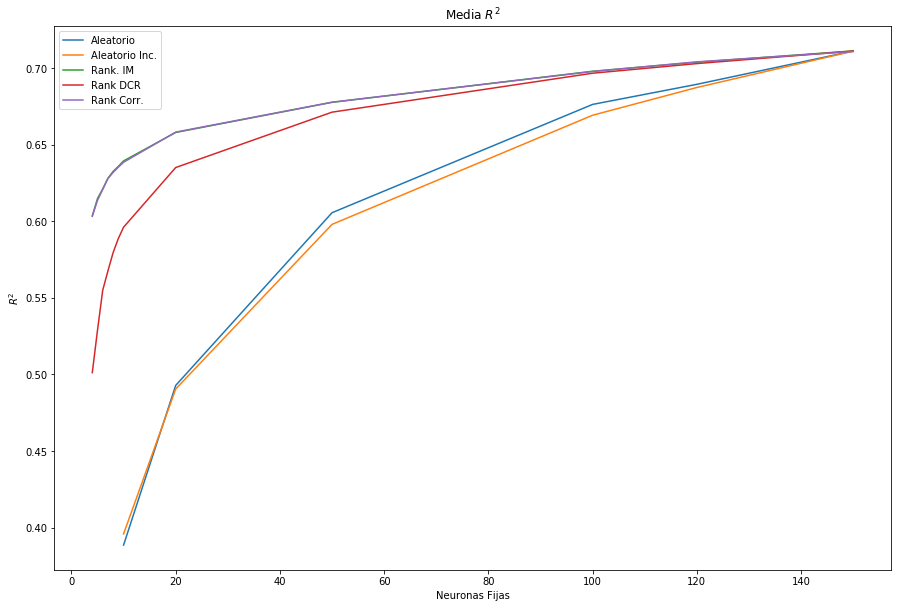

In [14]:
# All Mean R2 table & Plot
redrank = {0:"Rand",1:"Inc. Rand",2:"MI Rank",4:"Corr Rank",3:"RF Rank"}
redrank = {0:"Aleatorio",1:"Aleatorio Inc.",2:"Rank. IM",4:"Rank Corr.",3:"Rank DCR"}
r2data = {}
for r in range(5):
    r2data[r]=[]
    print("%10s"%redrank[r],end=" ")
    for f in [4,5,6,7,8,9,10,20,50,100,120,150]:
        if r in [0,1]:
            if f in [4,5,6,7,8,9]:
                print("%7s"%"-",end=" ")
                r2data[r].append(np.nan)
                continue
        r2data[r].append(np.mean([todasMedidas[n][(r,0,f,0,0)][1][1] for n in range(151)]))
        print("%7s"%np.round(np.mean([todasMedidas[n][(r,0,f,0,0)][1][1] for n in range(151)]),3),end=" ")
    print()

plt.figure(figsize=(15,10))
for r in range(5):
    plt.plot([4,5,6,7,8,9,10,20,50,100,120,150],r2data[r],label=redrank[r])
plt.title("Media $R^2$")
plt.xlabel("Neuronas Fijas")
plt.ylabel("$R^2$")
plt.legend()
plt.show()

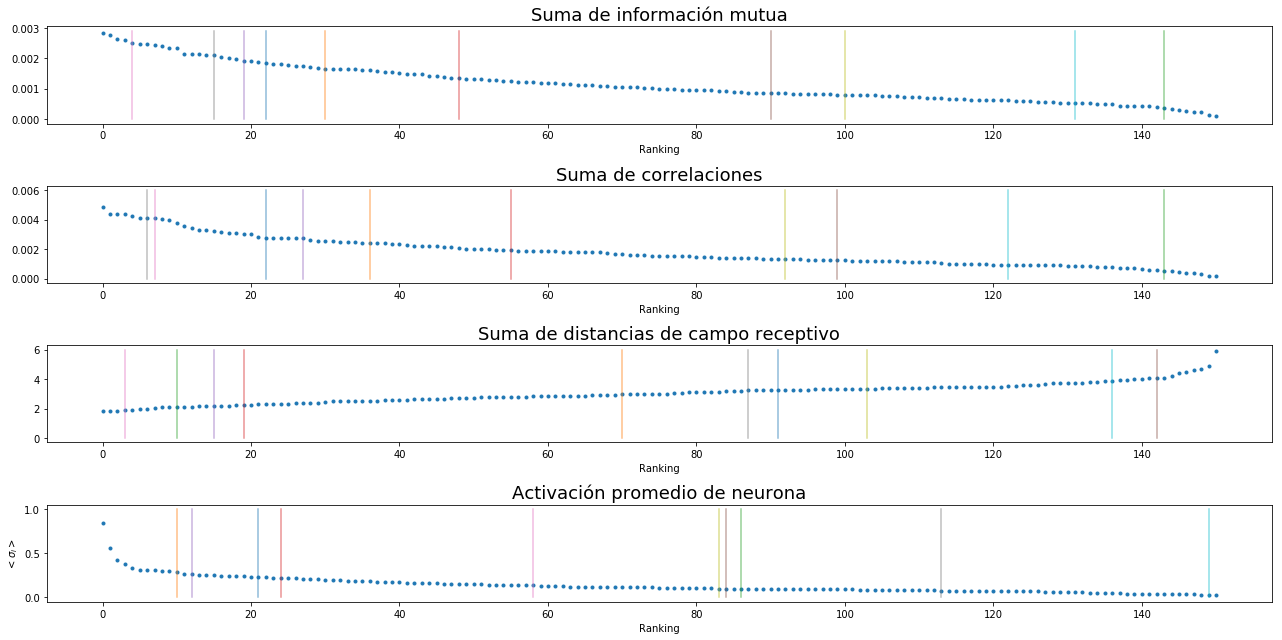

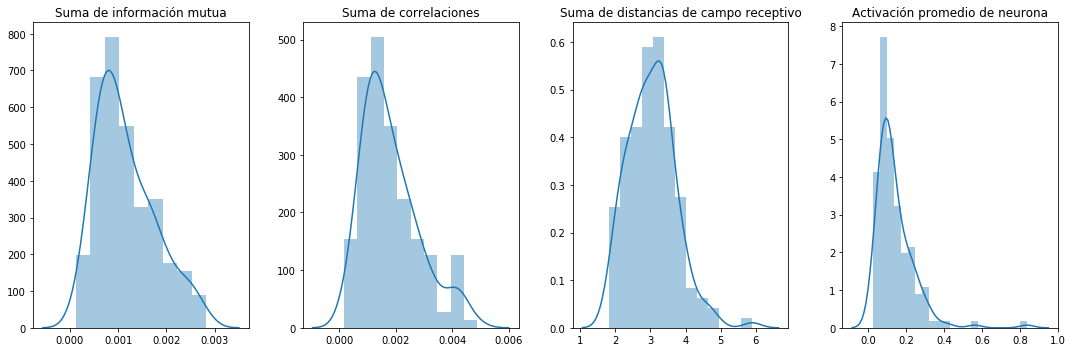

In [28]:
### 6 - Generación de visualizaciones
#### Función de visualización de raster/spRate v/s su predicción correspondiente
def spRateVis(r,f,s,window,size): #ranking fixed sample
    predicted = predicciones[(r,0,f,s,0)][1] #datos
    #preSpRate = np.array([np.sum(predicted[i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    spRate = np.array([np.sum(RASTER[TP][i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    plt.figure(figsize=(25,5))
    plt.plot(range(3000),predicted[:3000])
    plt.plot(range(3000),spRate[:3000])
    plt.title("cosa")
    plt.xlabel("t")
    plt.ylabel("SpikeRate")
    return 0
#### Función para visualizar las métricas de rendimiento de las predicciones

#### Función para visualizar los espacios de métricas utilizadas

#### Función para visualizar la caracterización de una neurona (Activación,EspacioMI,EspacioR,EspacioRF)
"""
def caracterizacion2D(neuron = dataset["fixed"]):
    plt.figure(figsize=(18,9))
    plt.subplot(2,3,1)
    plt.title("Receptive Field Space",fontsize=18)
    plt.scatter(Dpoints[:,0],Dpoints[:,1],marker=".")
    plt.scatter(Dpoints[neuron,0],Dpoints[neuron,1],label="Target N={0}".format(neuron))
    plt.legend()
    plt.subplot(2,3,2)
    plt.title("Mutual Information Space",fontsize=18)
    plt.xlim(-0.005,0.005)
    plt.scatter(MIpoints[:,0],Dpoints[:,1],marker=".")
    plt.scatter(MIpoints[neuron,0],MIpoints[neuron,1],label="Target N={0}".format(neuron))
    plt.legend()
    plt.subplot(2,3,3)
    plt.title("Correlation Space",fontsize=18)
    plt.xlim(-0.005,0.005)
    plt.scatter(CCpoints[:,0],Dpoints[:,1],marker=".")
    plt.scatter(CCpoints[neuron,0],CCpoints[neuron,1],color="r",label="Target N={0}".format(neuron))
    plt.legend()
    plt.subplot(2,1,2)
    plt.title("Average Neuron activation",fontsize=18)
    plt.ylabel("$<\sigma_i>$")
    plt.xlabel("Neuron Ranking")
    sprank = sorted(np.sum(RASTER,axis=1)/RASTER.shape[1],reverse=1)
    plt.plot(range(RASTER.shape[0]),sprank,".")
    plt.plot([sprank.index(np.sum(RASTER,axis=1)[neuron]/RASTER.shape[1])]*2,[0.0,1.0],"r",alpha=0.5,label="Target N={0}".format(neuron))
    plt.legend()
    plt.tight_layout()
"""
    
def caracterizacion1D(neurons):
    fig = plt.figure(figsize=(18,9))
    plt.subplot(4,1,1)
    plt.title("Suma de información mutua",fontsize=18)
    mirank = sorted(np.sum(MI,axis=1)/MI.shape[1],reverse=1)
    plt.xlabel("Ranking")
    plt.plot(range(MI.shape[0]),mirank,".")
    for neuron in neurons:
        plt.plot([mirank.index(np.sum(MI,axis=1)[neuron]/MI.shape[1])]*2,[0.0,0.0029],alpha=0.5,label="Target N={0}".format(neuron))
    #plt.legend()
    plt.subplot(4,1,2)
    plt.title("Suma de correlaciones",fontsize=18)
    ccrank = sorted(np.sum(CC,axis=1)/CC.shape[1],reverse=1)
    plt.xlabel("Ranking")
    plt.plot(range(CC.shape[0]),ccrank,".")
    for neuron in neurons:
        plt.plot([ccrank.index(np.sum(CC,axis=1)[neuron]/CC.shape[1])]*2,[0.0,0.006],alpha=0.5,label="Target N={0}".format(neuron))
    #plt.legend()
    plt.subplot(4,1,3)
    plt.title("Suma de distancias de campo receptivo",fontsize=18)
    rfrank = sorted(np.sum(D,axis=1)/D.shape[1])
    plt.plot(range(D.shape[0]),rfrank,".")
    for neuron in neurons:
        plt.plot([rfrank.index(np.sum(D,axis=1)[neuron]/D.shape[1])]*2,[0.0,6],alpha=0.5,label="Target N={0}".format(neuron))
    plt.xlabel("Ranking")
    #plt.legend()
    plt.subplot(4,1,4)
    plt.title("Activación promedio de neurona",fontsize=18)
    plt.ylabel("$<\sigma_i>$")
    plt.xlabel("Ranking")
    sprank = sorted(np.sum(RASTER,axis=1)/RASTER.shape[1],reverse=1)
    plt.plot(range(RASTER.shape[0]),sprank,".")
    #plt.ylim(0.0,0.2)
    for neuron in neurons:
        plt.plot([sprank.index(np.sum(RASTER,axis=1)[neuron]/RASTER.shape[1])]*2,[0.0,1.0],alpha=0.5,label="Target N={0}".format(neuron))
    #plt.legend()
    plt.tight_layout()
    plt.show()
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.title("Suma de información mutua")
    sns.distplot(mirank)
    plt.subplot(1,4,2)
    plt.title("Suma de correlaciones")
    sns.distplot(ccrank)
    plt.subplot(1,4,3)
    plt.title("Suma de distancias de campo receptivo")
    sns.distplot(rfrank)
    plt.subplot(1,4,4)
    plt.title("Activación promedio de neurona")
    sns.distplot(sprank)
    plt.tight_layout()
    #return fig
    
def stats(neuron): #Avg SpRate, Sum(MI),Sum(D),Sum(C) & Ranks
    Dindex,Dsums = list(zip(*sorted(enumerate(np.sum(D,axis=1)),key=lambda x:x[1])))
    Cindex,Csums = list(zip(*sorted(enumerate(np.sum(CC,axis=1)),reverse=True,key=lambda x:x[1])))
    MIindex,MIsums = list(zip(*sorted(enumerate(np.sum(MI,axis=1)),reverse=True,key=lambda x:x[1])))
    SPindex,SPsums = list(zip(*sorted(enumerate(np.sum(RASTER,axis=1)),reverse=True,key=lambda x:x[1])))
    #for neuron in neurons:
    #    print("RF:{} - Cor:{} - MI:{} - SP:{}".format(MIindex.index(neuron),Cindex.index(neuron),Dindex.index(neuron),SPindex.index(neuron)))
    return [MIindex.index(neuron),Cindex.index(neuron),Dindex.index(neuron),SPindex.index(neuron)]
    #print("RF Distance:\n{0}\t#{1}\nSumMI:\n{2}\t#{3}\nSumCC\n{4}\t{5}".format(ds,Dsums.index(ds),ms,MIsums.index(ms),cs,Csums.index(cs)))


        

#interact(caracterizacion,neuron=IntSlider(min=0,max=N, step=1,value=dataset["fixed"]))

neuronset = [2,10,20,31,49,72,119,120,127,147]
caracterizacion1D(neuronset)
#stats(neuronset)

In [182]:
for T in []:
    ds = cargarDataset(T)
    enu = sorted(enumerate(MI[T]),key = lambda x:x[1],reverse=1)
    unzipe = list(list(zip(*list(enu)))[0])
    unzipe.remove(T)
    dedat = ds["2"]["150"][0]
    print(unzipe)
    print(dedat)
    plt.scatter(unzipe,dedat,marker=".")
ising = loadmat("MatlabIsing/Models/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,147,2,1,9,0))
N=10
params = ising["params"] # N , N*(N-1)/2
#print(params[:,0],len(params[:,0]),N)
P = np.zeros((N,N)) #FullMatrix for indexing
P[np.triu_indices(N, 1)] = params[:,0][N:] #UpperTri Matrix
P = P+np.diag(params[:,0][:N]) #<h,sigma>

# No considerar de acá hacia abajo

In [173]:
def autocorrelate(V,lags=None):
    V = V/np.linalg.norm(V)
    if lags == None:
        return np.correlate(V,V,"full")
    return np.correlate(V,V,"full")[int(len(V)-lags)-1:int(len(V)+lags)]
def spr(V,I):
    return np.array([np.sum(V[i:i+I]) for i in range(0,len(V)-I)])/(1/TBASE)
#SpikeRates
sprates = [spr(RASTER[i],50) for i in range(N)]

LAGS = 1600
#plt.figure(figsize=(25,3))
#plt.plot(np.arange(-LAGS,LAGS+1,1),np.sum([autocorrelate(sprates[i],LAGS) for i in range(N)],axis=0)/N)

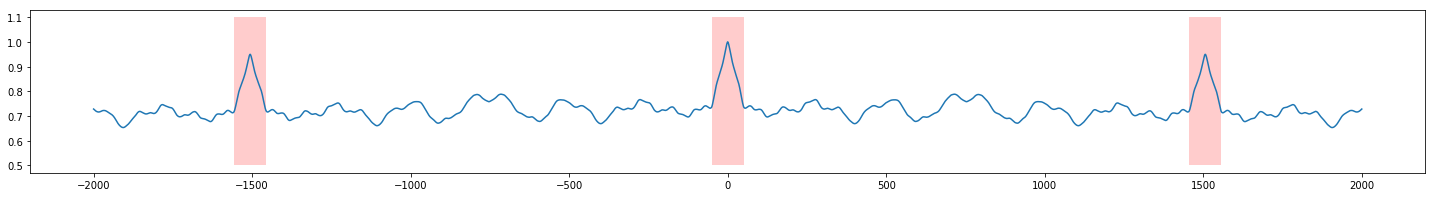

In [105]:
plt.figure(figsize=(25,3))
plt.plot(np.arange(-2000,2001),autocorrelate(sprates[5],2000))
plt.fill([-50,-50,50,50],[0.5,1.1,1.1,0.5],"r",alpha=0.2)
plt.fill([-1556,-1556,-1456,-1456],[0.5,1.1,1.1,0.5],"r",alpha=0.2)
plt.fill([1556,1556,1456,1456],[0.5,1.1,1.1,0.5],"r",alpha=0.2)

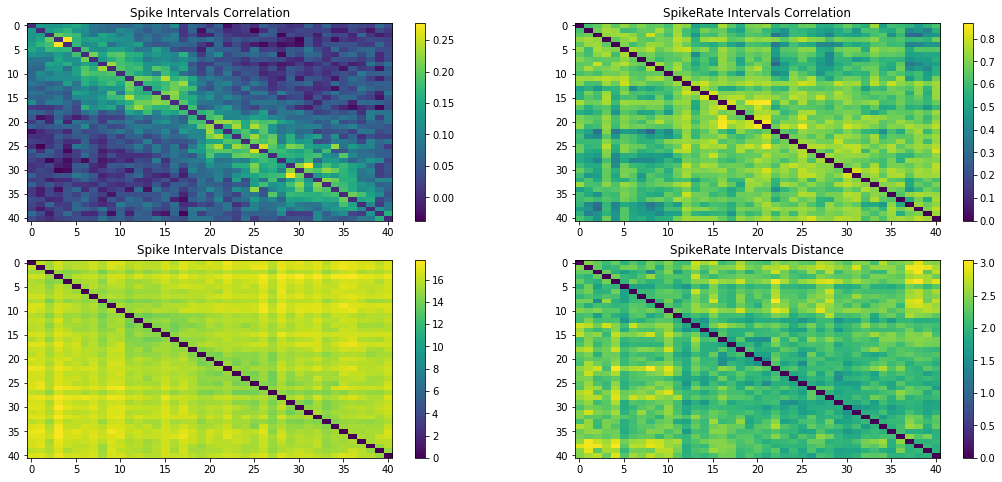

In [1047]:
spli = np.split(RASTER[120][:-63],41)
splispr = np.split(spr(RASTER[120],50)[:-13],41)
plt.figure(figsize=(18,8))
plt.subplot(2,2,1)
plt.title("Spike Intervals Correlation")
MAT = np.array([[ np.corrcoef(j,i)[0][1] for j in spli] for i in spli])-np.diag(np.ones(41))
plt.imshow(MAT,aspect="auto")
plt.colorbar()
plt.subplot(2,2,2)
plt.title("SpikeRate Intervals Correlation")
MAT = np.array([[ np.corrcoef(j,i)[0][1] for j in splispr] for i in splispr])-np.diag(np.ones(41))
plt.imshow(MAT,aspect="auto")
plt.colorbar()
plt.subplot(2,2,3)
plt.title("Spike Intervals Distance")
MAT = np.array([[ np.linalg.norm(j-i) for j in spli] for i in spli])
plt.imshow(MAT,aspect="auto")
plt.colorbar()
plt.subplot(2,2,4)
plt.title("SpikeRate Intervals Distance")
MAT = np.array([[ np.linalg.norm(j-i) for j in splispr] for i in splispr])
plt.imshow(MAT,aspect="auto")
plt.colorbar()


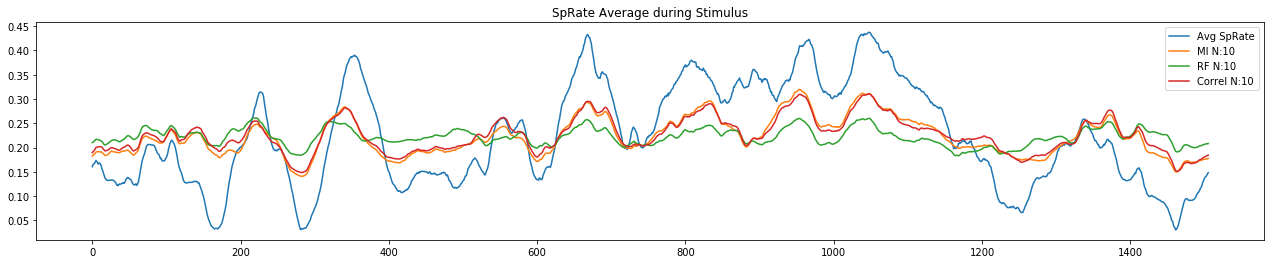

In [1095]:
splispr = np.split(spr(RASTER[TP],50)[:-13],41)
plt.figure(figsize=(22,4))
plt.title("SpRate Average during Stimulus")
#for n in range(41):
        #plt.plot(range(len(splispr[0])),splispr[n],"b",alpha=0.02)
plt.plot(range(len(splispr[0])),sum(splispr)/41,label="Avg SpRate")
for n in [10]:
    presplispr = sum(np.split(predicciones[(2,0,n,0,0)][1][:-13],41))/41
    plt.plot(range(len(splispr[0])),presplispr,label="MI N:{0}".format(n))
    presplispr = sum(np.split(predicciones[(3,0,n,0,0)][1][:-13],41))/41
    plt.plot(range(len(splispr[0])),presplispr,label="RF N:{0}".format(n))
    presplispr = sum(np.split(predicciones[(4,0,n,0,0)][1][:-13],41))/41
    plt.plot(range(len(splispr[0])),presplispr,label="Correl N:{0}".format(n))
plt.legend()
plt.savefig("predict.svg")

In [738]:
def modelCheck(num,verbose=0,lacking = 0):
    allmods = os.listdir("MatlabIsing/Models")
    current = 0
    tot = 0
    for rank in [0,1,2,3,4]: #tipo de ranking
        if rank in [0,1]:
            flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
        else:
            flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                for p in [0,1]:
                    tot+=1
                    nom = "E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,num,rank,p,f,s)
                    current+=nom in allmods
                    if verbose:
                        print (nom,nom in allmods)
                    if lacking and nom not in allmods:
                        print ("Ajustar('Rankings','Models','{0}');".format(nom))
    print ("Current Models: {0}/{1}".format(current,tot))
                
modelCheck(147,0,1)

Current Models: 210/210


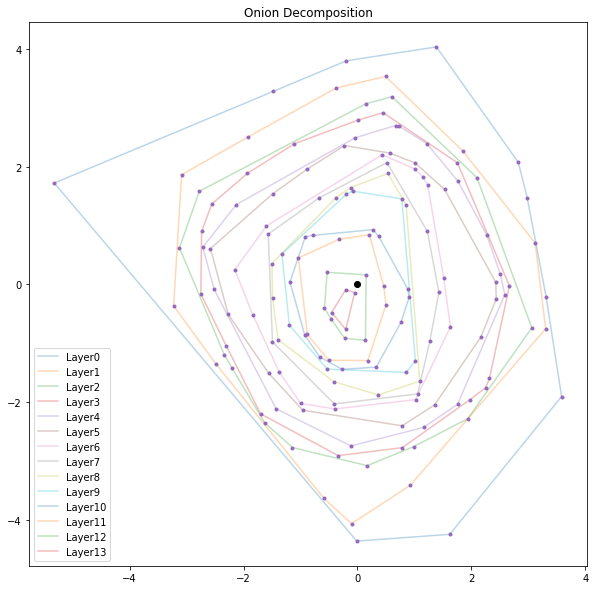

In [763]:

def onionDecomposition(points,plot=1):
    layerPoints = {} #layer plot tuples
    layerIndexes = {}
    cpoints = points #copy
    lindex = 0
    while len(points)>2:
        hull = ConvexHull(points)
        hv = hull.vertices[np.arange(0,len(hull.vertices)+1,1)%len(hull.vertices)]
        layerPoints[lindex] = (points[hv,0],points[hv,1])
        layerIndexes[lindex] = hv[:-1]
        points = points[list(set(range(len(points)))-set(hv))]
        lindex+=1
    if plot:
        plt.figure(figsize=(10,10))
        plt.title("Onion Decomposition")
        for l,coord in layerPoints.items():
            plt.plot(coord[0],coord[1],alpha=0.3,label="Layer{0}".format(l))
        plt.plot(cpoints[:,0],cpoints[:,1],".")
        plt.plot(np.average(cpoints[:,0]),np.average(cpoints[:,1]),"ok")
        plt.legend()
    return layerPoints,layerIndexes
    

puntos = np.random.rand(100, 2)
layerpoints,layerindexes = onionDecomposition(Dpoints)

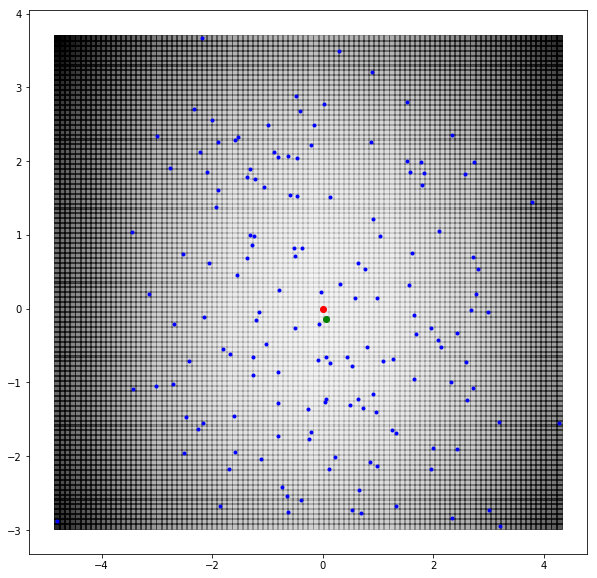

In [735]:
def minFinder(points,DEN=100):
    plt.figure(figsize=(10,10))
    plt.plot(points[:,0],points[:,1],".b")
    gx,gy = np.meshgrid(np.linspace(min(points[:,0]),max(points[:,0]),DEN),
                      np.linspace(min(points[:,1]),max(points[:,1]),DEN))
    gx,gy = gx.reshape(DEN**2),gy.reshape(DEN**2)
    dist = [sum(np.linalg.norm(points-np.array([gx[i],gy[i]]).T,axis=1)) for i in range(DEN**2)]
    plt.scatter(gx,gy,marker=",",color=[(0,0,0,(dist[i]/max(dist))**3) for i in range(DEN**2)])
    plt.plot(np.average(points[:,0]),np.average(points[:,1]),"or")
    plt.plot(gx[dist.index(min(dist))],gy[dist.index(min(dist))],"og")
minFinder(Dpoints)

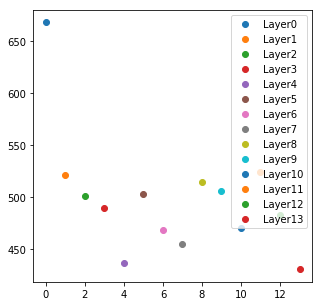

In [787]:
plt.figure(figsize=(5,5))
for layer,indexes in layerindexes.items():
    #plt.plot([layer]*len(indexes),[sum(np.linalg.norm(Dpoints-Dpoints[i],axis=1)) for i in indexes],"o",label="Layer{0}".format(layer))
    plt.plot([layer],np.average([sum(np.linalg.norm(Dpoints-Dpoints[i],axis=1)) for i in indexes]),"o",label="Layer{0}".format(layer))
plt.legend()

In [801]:
prompoint = np.array([np.average(Dpoints[:,0]),np.average(Dpoints[:,1])])
distoprom = np.linalg.norm(Dpoints-prompoint,axis=1)
totalsums = [sum(np.linalg.norm(Dpoints-Dpoints[i],axis=1)) for i in range(Dpoints.shape[0])]

In [150]:
os.listdir("/home/iampuero/Downloads")
for n in [11,21,51,101,121,151]:
    ising = loadmat("MatlabIsing/Models/E0C3T0.02N20R0P0F{0}S0.mat".format(n-1))
    params = ising["params"] # N , N*(N-1)/2
    #print(params[:,0],len(params[:,0]),N)
    P = np.zeros((n,n)) #FullMatrix for indexing
    P[np.triu_indices(n, 1)] = params[:,0][n:] #UpperTri Matrix
    H = params[:,0][:n]
    np.savetxt("/home/iampuero/Downloads/IsingParams/N{0}H.txt".format(n),H,fmt="%.5f")
    np.savetxt("/home/iampuero/Downloads/IsingParams/N{0}J.txt".format(n),P,fmt="%.5f")

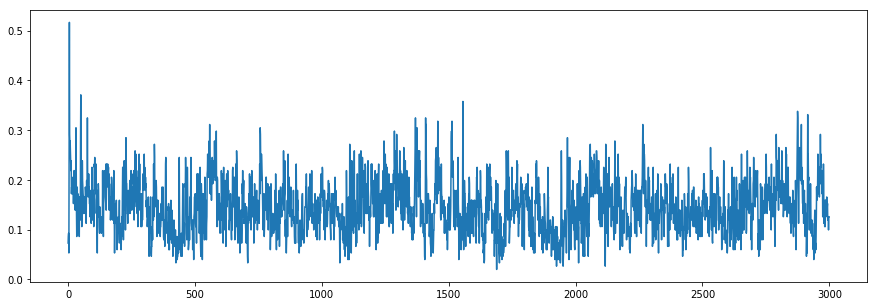

In [187]:
plt.figure(figsize=(15,5))
totalact = np.sum(RASTER,axis=0)
totsp = np.array([np.sum(data[i:i+50]) for i in range(0,T-window)])/(1/TBASE)

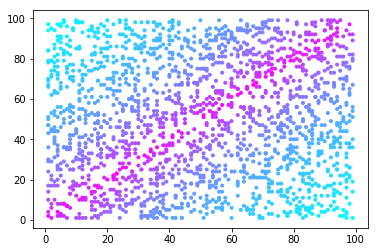

In [39]:
a = np.random.randint(1,100,2000)
b = np.random.randint(1,100,2000)
dists = np.array([np.sqrt(abs(a[n]-b[n])/np.sqrt(2)) for n in range(2000)])
dists/=max(dists)
plt.scatter(a,b,c=[[1-d,d,1] for d in dists],marker=".")

In [87]:
import jpype
jpype.__version__

'0.6.3'

In [21]:
D = loadmat("../Data/rfOverlap.mat")["rfDist"][0]

In [23]:
D.shape

(151, 151)